# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
_______________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 0s 4ms/step - loss: 250.0239 - y1_output_loss: 128.4805 - y2_output_loss: 121.5434 - y1_output_root_mean_squared_error: 11.3349 - y2_output_root_mean_squared_error: 11.0247 - val_loss: 45.2825 - val_y1_output_loss: 14.7726 - val_y2_output_loss: 30.5099 - val_y1_output_root_mean_squared_error: 3.8435 - val_y2_output_root_mean_squared_error: 5.5236
Epoch 2/500
62/62 [==============================] - 0s 973us/step - loss: 34.4529 - y1_output_loss: 13.0687 - y2_output_loss: 21.3841 - y1_output_root_mean_squared_error: 3.6151 - y2_output_root_mean_squared_error: 4.6243 - val_loss: 27.0500 - val_y1_output_loss: 8.1307 - val_y2_output_loss: 18.9193 - val_y1_output_root_mean_squared_error: 2.8514 - val_y2_output_root_mean_squared_error: 4.3496
Epoch 3/500
62/62 [==============================] - 0s 946us/step - loss: 28.9366 - y1_output_loss: 10.5704 - y2_output_loss: 18.3662 - y1_output_root_mean_squared_error: 3.2512 - y2_output_root_mean

Epoch 21/500
62/62 [==============================] - 0s 919us/step - loss: 13.7635 - y1_output_loss: 5.1357 - y2_output_loss: 8.6278 - y1_output_root_mean_squared_error: 2.2662 - y2_output_root_mean_squared_error: 2.9373 - val_loss: 11.0376 - val_y1_output_loss: 4.7084 - val_y2_output_loss: 6.3292 - val_y1_output_root_mean_squared_error: 2.1699 - val_y2_output_root_mean_squared_error: 2.5158
Epoch 22/500
62/62 [==============================] - 0s 847us/step - loss: 13.6864 - y1_output_loss: 4.8742 - y2_output_loss: 8.8122 - y1_output_root_mean_squared_error: 2.2078 - y2_output_root_mean_squared_error: 2.9685 - val_loss: 16.5437 - val_y1_output_loss: 6.3211 - val_y2_output_loss: 10.2226 - val_y1_output_root_mean_squared_error: 2.5142 - val_y2_output_root_mean_squared_error: 3.1973
Epoch 23/500
62/62 [==============================] - 0s 865us/step - loss: 13.8571 - y1_output_loss: 4.7992 - y2_output_loss: 9.0579 - y1_output_root_mean_squared_error: 2.1907 - y2_output_root_mean_squared

Epoch 42/500
62/62 [==============================] - 0s 873us/step - loss: 7.5502 - y1_output_loss: 2.1514 - y2_output_loss: 5.3988 - y1_output_root_mean_squared_error: 1.4668 - y2_output_root_mean_squared_error: 2.3235 - val_loss: 6.2128 - val_y1_output_loss: 2.5863 - val_y2_output_loss: 3.6265 - val_y1_output_root_mean_squared_error: 1.6082 - val_y2_output_root_mean_squared_error: 1.9043
Epoch 43/500
62/62 [==============================] - 0s 897us/step - loss: 8.4550 - y1_output_loss: 2.5537 - y2_output_loss: 5.9013 - y1_output_root_mean_squared_error: 1.5980 - y2_output_root_mean_squared_error: 2.4293 - val_loss: 23.2390 - val_y1_output_loss: 8.1376 - val_y2_output_loss: 15.1014 - val_y1_output_root_mean_squared_error: 2.8526 - val_y2_output_root_mean_squared_error: 3.8861
Epoch 44/500
62/62 [==============================] - 0s 885us/step - loss: 7.8277 - y1_output_loss: 2.3261 - y2_output_loss: 5.5015 - y1_output_root_mean_squared_error: 1.5252 - y2_output_root_mean_squared_err

Epoch 63/500
62/62 [==============================] - 0s 883us/step - loss: 5.1292 - y1_output_loss: 1.2413 - y2_output_loss: 3.8879 - y1_output_root_mean_squared_error: 1.1141 - y2_output_root_mean_squared_error: 1.9718 - val_loss: 5.0596 - val_y1_output_loss: 2.5477 - val_y2_output_loss: 2.5120 - val_y1_output_root_mean_squared_error: 1.5961 - val_y2_output_root_mean_squared_error: 1.5849
Epoch 64/500
62/62 [==============================] - 0s 971us/step - loss: 4.5128 - y1_output_loss: 1.1723 - y2_output_loss: 3.3405 - y1_output_root_mean_squared_error: 1.0827 - y2_output_root_mean_squared_error: 1.8277 - val_loss: 5.0003 - val_y1_output_loss: 1.7370 - val_y2_output_loss: 3.2633 - val_y1_output_root_mean_squared_error: 1.3180 - val_y2_output_root_mean_squared_error: 1.8065
Epoch 65/500
62/62 [==============================] - 0s 927us/step - loss: 7.1467 - y1_output_loss: 1.8958 - y2_output_loss: 5.2510 - y1_output_root_mean_squared_error: 1.3769 - y2_output_root_mean_squared_error

Epoch 84/500
62/62 [==============================] - 0s 915us/step - loss: 3.6837 - y1_output_loss: 0.7995 - y2_output_loss: 2.8843 - y1_output_root_mean_squared_error: 0.8941 - y2_output_root_mean_squared_error: 1.6983 - val_loss: 5.3285 - val_y1_output_loss: 1.3045 - val_y2_output_loss: 4.0240 - val_y1_output_root_mean_squared_error: 1.1422 - val_y2_output_root_mean_squared_error: 2.0060
Epoch 85/500
62/62 [==============================] - 0s 1ms/step - loss: 3.8426 - y1_output_loss: 0.9376 - y2_output_loss: 2.9049 - y1_output_root_mean_squared_error: 0.9683 - y2_output_root_mean_squared_error: 1.7044 - val_loss: 2.7720 - val_y1_output_loss: 0.8348 - val_y2_output_loss: 1.9372 - val_y1_output_root_mean_squared_error: 0.9137 - val_y2_output_root_mean_squared_error: 1.3918
Epoch 86/500
62/62 [==============================] - 0s 911us/step - loss: 11.7367 - y1_output_loss: 3.7131 - y2_output_loss: 8.0236 - y1_output_root_mean_squared_error: 1.9270 - y2_output_root_mean_squared_error:

Epoch 105/500
62/62 [==============================] - 0s 847us/step - loss: 3.5032 - y1_output_loss: 0.7170 - y2_output_loss: 2.7862 - y1_output_root_mean_squared_error: 0.8468 - y2_output_root_mean_squared_error: 1.6692 - val_loss: 3.1961 - val_y1_output_loss: 0.9623 - val_y2_output_loss: 2.2339 - val_y1_output_root_mean_squared_error: 0.9809 - val_y2_output_root_mean_squared_error: 1.4946
Epoch 106/500
62/62 [==============================] - 0s 921us/step - loss: 6.8522 - y1_output_loss: 1.9461 - y2_output_loss: 4.9061 - y1_output_root_mean_squared_error: 1.3950 - y2_output_root_mean_squared_error: 2.2150 - val_loss: 2.2459 - val_y1_output_loss: 0.5659 - val_y2_output_loss: 1.6800 - val_y1_output_root_mean_squared_error: 0.7522 - val_y2_output_root_mean_squared_error: 1.2962
Epoch 107/500
62/62 [==============================] - 0s 867us/step - loss: 3.3654 - y1_output_loss: 0.7951 - y2_output_loss: 2.5703 - y1_output_root_mean_squared_error: 0.8917 - y2_output_root_mean_squared_er

Epoch 126/500
62/62 [==============================] - 0s 827us/step - loss: 3.2139 - y1_output_loss: 0.7794 - y2_output_loss: 2.4345 - y1_output_root_mean_squared_error: 0.8828 - y2_output_root_mean_squared_error: 1.5603 - val_loss: 2.8776 - val_y1_output_loss: 0.6516 - val_y2_output_loss: 2.2260 - val_y1_output_root_mean_squared_error: 0.8072 - val_y2_output_root_mean_squared_error: 1.4920
Epoch 127/500
62/62 [==============================] - 0s 841us/step - loss: 2.5818 - y1_output_loss: 0.5333 - y2_output_loss: 2.0485 - y1_output_root_mean_squared_error: 0.7303 - y2_output_root_mean_squared_error: 1.4313 - val_loss: 2.2709 - val_y1_output_loss: 0.7763 - val_y2_output_loss: 1.4946 - val_y1_output_root_mean_squared_error: 0.8811 - val_y2_output_root_mean_squared_error: 1.2225
Epoch 128/500
62/62 [==============================] - 0s 844us/step - loss: 2.7918 - y1_output_loss: 0.5936 - y2_output_loss: 2.1982 - y1_output_root_mean_squared_error: 0.7704 - y2_output_root_mean_squared_er

Epoch 147/500
62/62 [==============================] - 0s 922us/step - loss: 2.2874 - y1_output_loss: 0.4888 - y2_output_loss: 1.7985 - y1_output_root_mean_squared_error: 0.6992 - y2_output_root_mean_squared_error: 1.3411 - val_loss: 1.4988 - val_y1_output_loss: 0.3598 - val_y2_output_loss: 1.1391 - val_y1_output_root_mean_squared_error: 0.5998 - val_y2_output_root_mean_squared_error: 1.0673
Epoch 148/500
62/62 [==============================] - 0s 855us/step - loss: 1.9599 - y1_output_loss: 0.3576 - y2_output_loss: 1.6023 - y1_output_root_mean_squared_error: 0.5980 - y2_output_root_mean_squared_error: 1.2658 - val_loss: 1.4720 - val_y1_output_loss: 0.3421 - val_y2_output_loss: 1.1299 - val_y1_output_root_mean_squared_error: 0.5849 - val_y2_output_root_mean_squared_error: 1.0630
Epoch 149/500
62/62 [==============================] - 0s 862us/step - loss: 2.2128 - y1_output_loss: 0.3921 - y2_output_loss: 1.8207 - y1_output_root_mean_squared_error: 0.6262 - y2_output_root_mean_squared_er

Epoch 168/500
62/62 [==============================] - 0s 898us/step - loss: 2.0065 - y1_output_loss: 0.3341 - y2_output_loss: 1.6724 - y1_output_root_mean_squared_error: 0.5780 - y2_output_root_mean_squared_error: 1.2932 - val_loss: 7.1417 - val_y1_output_loss: 1.4271 - val_y2_output_loss: 5.7146 - val_y1_output_root_mean_squared_error: 1.1946 - val_y2_output_root_mean_squared_error: 2.3905
Epoch 169/500
62/62 [==============================] - 0s 1ms/step - loss: 3.3176 - y1_output_loss: 0.7832 - y2_output_loss: 2.5344 - y1_output_root_mean_squared_error: 0.8850 - y2_output_root_mean_squared_error: 1.5920 - val_loss: 2.0616 - val_y1_output_loss: 0.8706 - val_y2_output_loss: 1.1909 - val_y1_output_root_mean_squared_error: 0.9331 - val_y2_output_root_mean_squared_error: 1.0913
Epoch 170/500
62/62 [==============================] - 0s 964us/step - loss: 2.2363 - y1_output_loss: 0.4381 - y2_output_loss: 1.7981 - y1_output_root_mean_squared_error: 0.6619 - y2_output_root_mean_squared_erro

Epoch 189/500
62/62 [==============================] - 0s 877us/step - loss: 1.5862 - y1_output_loss: 0.3183 - y2_output_loss: 1.2679 - y1_output_root_mean_squared_error: 0.5642 - y2_output_root_mean_squared_error: 1.1260 - val_loss: 1.3770 - val_y1_output_loss: 0.3072 - val_y2_output_loss: 1.0698 - val_y1_output_root_mean_squared_error: 0.5543 - val_y2_output_root_mean_squared_error: 1.0343
Epoch 190/500
62/62 [==============================] - 0s 909us/step - loss: 1.6624 - y1_output_loss: 0.3134 - y2_output_loss: 1.3490 - y1_output_root_mean_squared_error: 0.5598 - y2_output_root_mean_squared_error: 1.1615 - val_loss: 6.9439 - val_y1_output_loss: 0.6744 - val_y2_output_loss: 6.2695 - val_y1_output_root_mean_squared_error: 0.8212 - val_y2_output_root_mean_squared_error: 2.5039
Epoch 191/500
62/62 [==============================] - 0s 916us/step - loss: 2.2025 - y1_output_loss: 0.3634 - y2_output_loss: 1.8391 - y1_output_root_mean_squared_error: 0.6028 - y2_output_root_mean_squared_er

Epoch 210/500
62/62 [==============================] - 0s 915us/step - loss: 1.5475 - y1_output_loss: 0.2602 - y2_output_loss: 1.2873 - y1_output_root_mean_squared_error: 0.5101 - y2_output_root_mean_squared_error: 1.1346 - val_loss: 2.0305 - val_y1_output_loss: 0.6243 - val_y2_output_loss: 1.4061 - val_y1_output_root_mean_squared_error: 0.7901 - val_y2_output_root_mean_squared_error: 1.1858
Epoch 211/500
62/62 [==============================] - 0s 895us/step - loss: 1.3602 - y1_output_loss: 0.2399 - y2_output_loss: 1.1203 - y1_output_root_mean_squared_error: 0.4898 - y2_output_root_mean_squared_error: 1.0584 - val_loss: 1.3624 - val_y1_output_loss: 0.2281 - val_y2_output_loss: 1.1343 - val_y1_output_root_mean_squared_error: 0.4776 - val_y2_output_root_mean_squared_error: 1.0650
Epoch 212/500
62/62 [==============================] - 0s 916us/step - loss: 1.5756 - y1_output_loss: 0.2661 - y2_output_loss: 1.3096 - y1_output_root_mean_squared_error: 0.5158 - y2_output_root_mean_squared_er

Epoch 231/500
62/62 [==============================] - 0s 907us/step - loss: 1.2064 - y1_output_loss: 0.2001 - y2_output_loss: 1.0063 - y1_output_root_mean_squared_error: 0.4473 - y2_output_root_mean_squared_error: 1.0031 - val_loss: 1.1453 - val_y1_output_loss: 0.2773 - val_y2_output_loss: 0.8679 - val_y1_output_root_mean_squared_error: 0.5266 - val_y2_output_root_mean_squared_error: 0.9316
Epoch 232/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1967 - y1_output_loss: 0.2365 - y2_output_loss: 0.9602 - y1_output_root_mean_squared_error: 0.4864 - y2_output_root_mean_squared_error: 0.9799 - val_loss: 3.9080 - val_y1_output_loss: 0.5507 - val_y2_output_loss: 3.3573 - val_y1_output_root_mean_squared_error: 0.7421 - val_y2_output_root_mean_squared_error: 1.8323
Epoch 233/500
62/62 [==============================] - 0s 889us/step - loss: 1.5051 - y1_output_loss: 0.2800 - y2_output_loss: 1.2251 - y1_output_root_mean_squared_error: 0.5292 - y2_output_root_mean_squared_erro

Epoch 252/500
62/62 [==============================] - 0s 1ms/step - loss: 1.5732 - y1_output_loss: 0.3054 - y2_output_loss: 1.2678 - y1_output_root_mean_squared_error: 0.5527 - y2_output_root_mean_squared_error: 1.1259 - val_loss: 0.8990 - val_y1_output_loss: 0.2408 - val_y2_output_loss: 0.6582 - val_y1_output_root_mean_squared_error: 0.4907 - val_y2_output_root_mean_squared_error: 0.8113
Epoch 253/500
62/62 [==============================] - 0s 878us/step - loss: 0.9745 - y1_output_loss: 0.2418 - y2_output_loss: 0.7327 - y1_output_root_mean_squared_error: 0.4917 - y2_output_root_mean_squared_error: 0.8560 - val_loss: 1.2961 - val_y1_output_loss: 0.3392 - val_y2_output_loss: 0.9570 - val_y1_output_root_mean_squared_error: 0.5824 - val_y2_output_root_mean_squared_error: 0.9783
Epoch 254/500
62/62 [==============================] - 0s 924us/step - loss: 1.2052 - y1_output_loss: 0.2394 - y2_output_loss: 0.9658 - y1_output_root_mean_squared_error: 0.4893 - y2_output_root_mean_squared_erro

Epoch 273/500
62/62 [==============================] - 0s 854us/step - loss: 0.9317 - y1_output_loss: 0.1802 - y2_output_loss: 0.7514 - y1_output_root_mean_squared_error: 0.4245 - y2_output_root_mean_squared_error: 0.8669 - val_loss: 2.2164 - val_y1_output_loss: 0.4018 - val_y2_output_loss: 1.8147 - val_y1_output_root_mean_squared_error: 0.6339 - val_y2_output_root_mean_squared_error: 1.3471
Epoch 274/500
62/62 [==============================] - 0s 888us/step - loss: 0.9933 - y1_output_loss: 0.2022 - y2_output_loss: 0.7912 - y1_output_root_mean_squared_error: 0.4496 - y2_output_root_mean_squared_error: 0.8895 - val_loss: 1.3456 - val_y1_output_loss: 0.3264 - val_y2_output_loss: 1.0193 - val_y1_output_root_mean_squared_error: 0.5713 - val_y2_output_root_mean_squared_error: 1.0096
Epoch 275/500
62/62 [==============================] - 0s 878us/step - loss: 0.8399 - y1_output_loss: 0.1797 - y2_output_loss: 0.6602 - y1_output_root_mean_squared_error: 0.4239 - y2_output_root_mean_squared_er

Epoch 294/500
62/62 [==============================] - 0s 865us/step - loss: 0.7542 - y1_output_loss: 0.2017 - y2_output_loss: 0.5525 - y1_output_root_mean_squared_error: 0.4491 - y2_output_root_mean_squared_error: 0.7433 - val_loss: 1.6137 - val_y1_output_loss: 0.4136 - val_y2_output_loss: 1.2001 - val_y1_output_root_mean_squared_error: 0.6431 - val_y2_output_root_mean_squared_error: 1.0955
Epoch 295/500
62/62 [==============================] - 0s 868us/step - loss: 0.8238 - y1_output_loss: 0.1854 - y2_output_loss: 0.6385 - y1_output_root_mean_squared_error: 0.4305 - y2_output_root_mean_squared_error: 0.7990 - val_loss: 1.2246 - val_y1_output_loss: 0.2693 - val_y2_output_loss: 0.9553 - val_y1_output_root_mean_squared_error: 0.5189 - val_y2_output_root_mean_squared_error: 0.9774
Epoch 296/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7229 - y1_output_loss: 0.1770 - y2_output_loss: 0.5459 - y1_output_root_mean_squared_error: 0.4207 - y2_output_root_mean_squared_erro

Epoch 315/500
62/62 [==============================] - 0s 910us/step - loss: 0.6530 - y1_output_loss: 0.1854 - y2_output_loss: 0.4676 - y1_output_root_mean_squared_error: 0.4306 - y2_output_root_mean_squared_error: 0.6838 - val_loss: 0.9374 - val_y1_output_loss: 0.2560 - val_y2_output_loss: 0.6815 - val_y1_output_root_mean_squared_error: 0.5060 - val_y2_output_root_mean_squared_error: 0.8255
Epoch 316/500
62/62 [==============================] - 0s 900us/step - loss: 0.6763 - y1_output_loss: 0.1643 - y2_output_loss: 0.5120 - y1_output_root_mean_squared_error: 0.4054 - y2_output_root_mean_squared_error: 0.7156 - val_loss: 0.9002 - val_y1_output_loss: 0.1764 - val_y2_output_loss: 0.7239 - val_y1_output_root_mean_squared_error: 0.4199 - val_y2_output_root_mean_squared_error: 0.8508
Epoch 317/500
62/62 [==============================] - 0s 881us/step - loss: 0.6985 - y1_output_loss: 0.1662 - y2_output_loss: 0.5323 - y1_output_root_mean_squared_error: 0.4077 - y2_output_root_mean_squared_er

Epoch 336/500
62/62 [==============================] - 0s 881us/step - loss: 0.7855 - y1_output_loss: 0.2087 - y2_output_loss: 0.5768 - y1_output_root_mean_squared_error: 0.4568 - y2_output_root_mean_squared_error: 0.7595 - val_loss: 0.8107 - val_y1_output_loss: 0.2061 - val_y2_output_loss: 0.6046 - val_y1_output_root_mean_squared_error: 0.4540 - val_y2_output_root_mean_squared_error: 0.7775
Epoch 337/500
62/62 [==============================] - 0s 914us/step - loss: 0.7134 - y1_output_loss: 0.1911 - y2_output_loss: 0.5223 - y1_output_root_mean_squared_error: 0.4371 - y2_output_root_mean_squared_error: 0.7227 - val_loss: 0.9466 - val_y1_output_loss: 0.2326 - val_y2_output_loss: 0.7140 - val_y1_output_root_mean_squared_error: 0.4823 - val_y2_output_root_mean_squared_error: 0.8450
Epoch 338/500
62/62 [==============================] - 0s 881us/step - loss: 0.6925 - y1_output_loss: 0.1816 - y2_output_loss: 0.5109 - y1_output_root_mean_squared_error: 0.4261 - y2_output_root_mean_squared_er

Epoch 357/500
62/62 [==============================] - 0s 887us/step - loss: 0.6009 - y1_output_loss: 0.1546 - y2_output_loss: 0.4463 - y1_output_root_mean_squared_error: 0.3931 - y2_output_root_mean_squared_error: 0.6681 - val_loss: 5.2568 - val_y1_output_loss: 0.4826 - val_y2_output_loss: 4.7742 - val_y1_output_root_mean_squared_error: 0.6947 - val_y2_output_root_mean_squared_error: 2.1850
Epoch 358/500
62/62 [==============================] - 0s 902us/step - loss: 0.7506 - y1_output_loss: 0.1716 - y2_output_loss: 0.5790 - y1_output_root_mean_squared_error: 0.4143 - y2_output_root_mean_squared_error: 0.7609 - val_loss: 1.5895 - val_y1_output_loss: 0.2142 - val_y2_output_loss: 1.3753 - val_y1_output_root_mean_squared_error: 0.4629 - val_y2_output_root_mean_squared_error: 1.1727
Epoch 359/500
62/62 [==============================] - 0s 847us/step - loss: 0.5667 - y1_output_loss: 0.1564 - y2_output_loss: 0.4103 - y1_output_root_mean_squared_error: 0.3955 - y2_output_root_mean_squared_er

Epoch 378/500
62/62 [==============================] - 0s 851us/step - loss: 0.4232 - y1_output_loss: 0.1368 - y2_output_loss: 0.2864 - y1_output_root_mean_squared_error: 0.3698 - y2_output_root_mean_squared_error: 0.5352 - val_loss: 1.6135 - val_y1_output_loss: 0.1941 - val_y2_output_loss: 1.4194 - val_y1_output_root_mean_squared_error: 0.4406 - val_y2_output_root_mean_squared_error: 1.1914
Epoch 379/500
62/62 [==============================] - 0s 905us/step - loss: 0.6879 - y1_output_loss: 0.1728 - y2_output_loss: 0.5151 - y1_output_root_mean_squared_error: 0.4157 - y2_output_root_mean_squared_error: 0.7177 - val_loss: 0.9114 - val_y1_output_loss: 0.2146 - val_y2_output_loss: 0.6969 - val_y1_output_root_mean_squared_error: 0.4632 - val_y2_output_root_mean_squared_error: 0.8348
Epoch 380/500
62/62 [==============================] - 0s 879us/step - loss: 0.5086 - y1_output_loss: 0.1361 - y2_output_loss: 0.3726 - y1_output_root_mean_squared_error: 0.3689 - y2_output_root_mean_squared_er

Epoch 399/500
62/62 [==============================] - 0s 912us/step - loss: 0.5601 - y1_output_loss: 0.1487 - y2_output_loss: 0.4114 - y1_output_root_mean_squared_error: 0.3856 - y2_output_root_mean_squared_error: 0.6414 - val_loss: 0.6369 - val_y1_output_loss: 0.1643 - val_y2_output_loss: 0.4726 - val_y1_output_root_mean_squared_error: 0.4053 - val_y2_output_root_mean_squared_error: 0.6875
Epoch 400/500
62/62 [==============================] - 0s 885us/step - loss: 0.4867 - y1_output_loss: 0.1397 - y2_output_loss: 0.3470 - y1_output_root_mean_squared_error: 0.3737 - y2_output_root_mean_squared_error: 0.5891 - val_loss: 1.3278 - val_y1_output_loss: 0.4662 - val_y2_output_loss: 0.8616 - val_y1_output_root_mean_squared_error: 0.6828 - val_y2_output_root_mean_squared_error: 0.9282
Epoch 401/500
62/62 [==============================] - 0s 882us/step - loss: 0.5550 - y1_output_loss: 0.1369 - y2_output_loss: 0.4181 - y1_output_root_mean_squared_error: 0.3700 - y2_output_root_mean_squared_er

Epoch 420/500
62/62 [==============================] - 0s 960us/step - loss: 0.3744 - y1_output_loss: 0.1176 - y2_output_loss: 0.2569 - y1_output_root_mean_squared_error: 0.3429 - y2_output_root_mean_squared_error: 0.5068 - val_loss: 0.7669 - val_y1_output_loss: 0.1774 - val_y2_output_loss: 0.5895 - val_y1_output_root_mean_squared_error: 0.4211 - val_y2_output_root_mean_squared_error: 0.7678
Epoch 421/500
62/62 [==============================] - 0s 929us/step - loss: 0.4752 - y1_output_loss: 0.1489 - y2_output_loss: 0.3263 - y1_output_root_mean_squared_error: 0.3859 - y2_output_root_mean_squared_error: 0.5712 - val_loss: 0.7698 - val_y1_output_loss: 0.1863 - val_y2_output_loss: 0.5835 - val_y1_output_root_mean_squared_error: 0.4316 - val_y2_output_root_mean_squared_error: 0.7639
Epoch 422/500
62/62 [==============================] - 0s 874us/step - loss: 0.4284 - y1_output_loss: 0.1352 - y2_output_loss: 0.2931 - y1_output_root_mean_squared_error: 0.3677 - y2_output_root_mean_squared_er

Epoch 441/500
62/62 [==============================] - 0s 834us/step - loss: 0.4231 - y1_output_loss: 0.1444 - y2_output_loss: 0.2787 - y1_output_root_mean_squared_error: 0.3800 - y2_output_root_mean_squared_error: 0.5279 - val_loss: 0.7890 - val_y1_output_loss: 0.1621 - val_y2_output_loss: 0.6269 - val_y1_output_root_mean_squared_error: 0.4027 - val_y2_output_root_mean_squared_error: 0.7918
Epoch 442/500
62/62 [==============================] - 0s 848us/step - loss: 0.4061 - y1_output_loss: 0.1246 - y2_output_loss: 0.2815 - y1_output_root_mean_squared_error: 0.3530 - y2_output_root_mean_squared_error: 0.5306 - val_loss: 0.8293 - val_y1_output_loss: 0.1921 - val_y2_output_loss: 0.6372 - val_y1_output_root_mean_squared_error: 0.4383 - val_y2_output_root_mean_squared_error: 0.7983
Epoch 443/500
62/62 [==============================] - 0s 825us/step - loss: 0.5431 - y1_output_loss: 0.1485 - y2_output_loss: 0.3946 - y1_output_root_mean_squared_error: 0.3854 - y2_output_root_mean_squared_er

Epoch 462/500
62/62 [==============================] - 0s 853us/step - loss: 0.4276 - y1_output_loss: 0.1364 - y2_output_loss: 0.2912 - y1_output_root_mean_squared_error: 0.3693 - y2_output_root_mean_squared_error: 0.5396 - val_loss: 0.7663 - val_y1_output_loss: 0.2279 - val_y2_output_loss: 0.5384 - val_y1_output_root_mean_squared_error: 0.4773 - val_y2_output_root_mean_squared_error: 0.7338
Epoch 463/500
62/62 [==============================] - 0s 856us/step - loss: 0.3987 - y1_output_loss: 0.1279 - y2_output_loss: 0.2709 - y1_output_root_mean_squared_error: 0.3576 - y2_output_root_mean_squared_error: 0.5205 - val_loss: 0.5815 - val_y1_output_loss: 0.1624 - val_y2_output_loss: 0.4191 - val_y1_output_root_mean_squared_error: 0.4030 - val_y2_output_root_mean_squared_error: 0.6474
Epoch 464/500
62/62 [==============================] - 0s 836us/step - loss: 0.5129 - y1_output_loss: 0.1569 - y2_output_loss: 0.3560 - y1_output_root_mean_squared_error: 0.3961 - y2_output_root_mean_squared_er

Epoch 483/500
62/62 [==============================] - 0s 842us/step - loss: 0.4495 - y1_output_loss: 0.1329 - y2_output_loss: 0.3166 - y1_output_root_mean_squared_error: 0.3645 - y2_output_root_mean_squared_error: 0.5627 - val_loss: 0.7788 - val_y1_output_loss: 0.1934 - val_y2_output_loss: 0.5854 - val_y1_output_root_mean_squared_error: 0.4398 - val_y2_output_root_mean_squared_error: 0.7651
Epoch 484/500
62/62 [==============================] - 0s 849us/step - loss: 0.4856 - y1_output_loss: 0.1565 - y2_output_loss: 0.3291 - y1_output_root_mean_squared_error: 0.3955 - y2_output_root_mean_squared_error: 0.5737 - val_loss: 0.7768 - val_y1_output_loss: 0.1732 - val_y2_output_loss: 0.6036 - val_y1_output_root_mean_squared_error: 0.4161 - val_y2_output_root_mean_squared_error: 0.7769
Epoch 485/500
62/62 [==============================] - 0s 827us/step - loss: 0.4743 - y1_output_loss: 0.1256 - y2_output_loss: 0.3487 - y1_output_root_mean_squared_error: 0.3544 - y2_output_root_mean_squared_er

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 1ms/step - loss: 0.7468 - y1_output_loss: 0.2327 - y2_output_loss: 0.5141 - y1_output_root_mean_squared_error: 0.4824 - y2_output_root_mean_squared_error: 0.7170
Loss = 0.7467678189277649, Y1_loss = 0.23270651698112488, Y1_mse = 0.4823966324329376, Y2_loss = 0.5140613317489624, Y2_mse = 0.7169806957244873


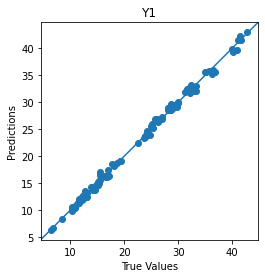

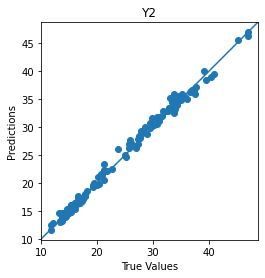

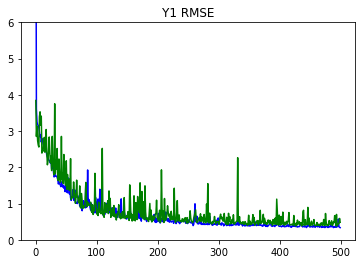

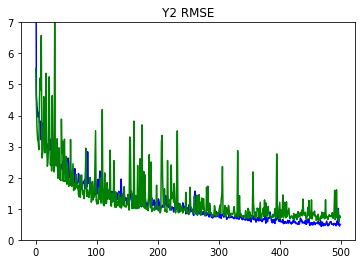

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)